In [129]:
%matplotlib inline

import os
import cmaps
import salem
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from myfunc import timer
from myfunc import DirMan
import config
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from itertools import combinations
# configuration
# resolution = "0p1"
resolution = "500"
region = [-180,180,-60,90]
data_path = f'/tera04/zhwei/xionghui/bedrock/run/{resolution}/'
post_data_path = '/tera04/zhwei/xionghui/bedrock/'
shp_path = '/tera04/zhwei/xionghui/bedrock/Shp/'
fig_path = f'/home/xuxh22/stu01/Bedrock/fig/{resolution}/'
path = '/home/xuxh22/stu01/Bedrock/'
if resolution == "0p1":
    size = 0.1
elif resolution == "500":
    size = 0.0005

print('python draw_g2_scatter.py')
print(data_path)
dir_man = DirMan(data_path)
dir_man.enter()
os.makedirs(f'{fig_path}/global_map_2', exist_ok=True)

shp = gpd.GeoDataFrame.from_file(shp_path+'World_CN/ne_10m_admin_0_countries_chn.shp')

pd.set_option('display.max_columns', None)
# font = {'family': 'Times New Roman'}
font = {'family': 'Arial'}
matplotlib.rc('font', **font)

params = {'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

font_properties = fm.FontProperties(weight='bold')

casename1 = 'bedrock_1'
path1 = f'{data_path}/cases/{casename1}/'
casename2 = 'bedrock_2'
path2 = f'{data_path}/cases/{casename2}/'
casename3 = 'bedrock_3'
path3 = f'{data_path}/cases/{casename3}/'

python draw_g2_scatter.py
/tera04/zhwei/xionghui/bedrock/run/500/
Entered /tera04/zhwei/xionghui/bedrock/run/500/


In [ ]:
def read_data(df1,var):
    paths = [path1, path2, path3]
    num = len(paths)
    comb_num = math.comb(num, 2)
    all_num = num + comb_num
    comb_paths = list(combinations(paths, 2))

    nmean = np.zeros(all_num)
    nmedian = np.zeros(all_num)
    nstd = np.zeros(all_num)
    nmax = np.zeros(all_num)
    nmin = np.zeros(all_num)

    for i,path in enumerate(paths):
        name = f'{path}{var}'
        nmean[i]=df1[name].mean()
        nmedian[i]=df1[name].median()
        nstd[i]=df1[name].std()
        nmax[i]=df1[name].max()
        nmin[i]=df1[name].min()
    
    new_name1 = ['Exp1','Exp2','Exp3']
    new_name2 = ['Exp1-Exp2','Exp1-Exp3','Exp2-Exp3']
    for j,two_path in enumerate(comb_paths):
        name1 = f'{two_path[0]}{var}'
        name2 = f'{two_path[1]}{var}'
        df1[new_name2[j]] = df1[name1] - df1[name2]
        nmean[j+num]=df1[new_name2[j]].mean()
        nmedian[j+num]=df1[new_name2[j]].median()
        nstd[j+num]=df1[new_name2[j]].std()
        nmax[j+num]=df1[new_name2[j]].max()
        nmin[j+num]=df1[new_name2[j]].min()

    var_prefix = var.split('_')[0]

    # Create a DataFrame with the statistics
    stats_df = pd.DataFrame({
        'mean': nmean,
        'median': nmedian,
        'std': nstd,
        'max': nmax,
        'min': nmin
    }, index=new_name1 + new_name2)

    stats_df.to_csv(f'{data_path}csv/Global_cases_{var_prefix}_stat.csv', index=True, index_label='Index', float_format='%.6f', encoding='utf-8-sig')

    return stats_df

In [174]:
def draw_exp(stats_df,diff=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib import ticker

    colours = ['#4f83ae','#f0734d', '#dbb355','#75ae6c', '#b16e45','#8f2887']

    if diff:
        df = stats_df.iloc[3:,:].copy()
        colours=colours[3:]
    else:
        df = stats_df.iloc[:3,:].copy()
        colours=colours[:3]

    # 定义类别列（用于颜色区分）
    df['category'] = pd.Categorical(df.index)


    # 定义要绘制的列
    cols = ['mean', 'median', 'std', 'max', 'min']
    x = [i for i, _ in enumerate(cols)]

    # 定义颜色（为 3 行数据分配 3 种颜色）
    
    colours = {df['category'].cat.categories[i]: colours[i] for i, _ in enumerate(df['category'].cat.categories)}

    def get_ticks(vmin, vmax):
        diff = vmax - vmin
        small_value = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
        large_value = sorted(set([int(i * 10**e) if i * 10**e > 10 else i * 10**e for e in range(4) for i in [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10] if i * 10**e <= 10000]))
        ALLOWED_TICKS = small_value + large_value
        TARGET_NUM_TICKS = 5
        ideal_tick = diff / TARGET_NUM_TICKS
        for tick in ALLOWED_TICKS:
            if tick >= ideal_tick:
                return tick
        return ALLOWED_TICKS[-1]

    # 设置 y 轴刻度和标签
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        num_range = (max_val-min_val)/val_range
        tick_labels = np.linspace(int(min_val),int(max_val),int(num_range)+1).astype(int)
        ticks = np.linspace(0,1,int(num_range)+1)
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels, size=20)

    # 数据标准化
    min_max_range = {}
    for col in cols:
        min_val, max_val = df[col].min(), df[col].max()
        print(min_val, max_val)
        val_range = int(get_ticks(min_val, max_val))
        min_val = int(min_val//val_range*val_range)
        max_val = int((max_val//val_range+1)*val_range)
        print(min_val, max_val, val_range)
        min_max_range[col] = [min_val, max_val, val_range]
        df[col] = np.true_divide(df[col] - min_val, max_val-min_val)

    # 创建子图（5列需要4个子图）
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(12, 6))

    # 绘制每行数据
    for i, ax in enumerate(axes):
        for idx in df.index:
            category = df.loc[idx, 'category']
            ax.plot(x, df.loc[idx, cols], colours[category], lw=3)
            # print(df.loc[idx, cols])
        ax.set_xlim([x[i], x[i+1]])
        ax.set_ylim(0,1)
        # ax.set_xlabel(cols[i], fontsize=14, color='black',weight='bold', labelpad=10)
        ax.xaxis.set_ticks_position('top')
        ax.spines['top'].set_linewidth(0)
        ax.spines['bottom'].set_linewidth(0)

    # 为每个子图设置刻度和 x 轴标签
    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=5)
        # ax.set_xticklabels([cols[dim]], size=32, weight='bold')
        ax.set_xticklabels([])
        ax.tick_params(axis='x', pad=20)

    # 处理最后一个子图的右侧 y 轴
    ax = plt.twinx(axes[-1])

    dim = len(axes)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    ax.spines['left'].set_position(('data', 4)) 
    ax.set_ylim(0,1)

    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    # ax.set_xticklabels([cols[-2], cols[-1]], size=32, weight='bold')

    ax.xaxis.set_ticks_position('top')
    set_ticks_for_axis(dim, ax, ticks=5)

    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(0)
    ax.tick_params(axis='x', pad=20)


    # 移除子图间距
    plt.subplots_adjust(wspace=0)

    # # 添加图例
    # plt.legend(
    #     [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df['category'].cat.categories],
    #     df['category'].cat.categories,
    #     bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    plt.show()

156.02963477157627 324.29437864754044
120 360 40
142.69823 314.87366
120 320 40
68.66454241015977 110.91122825321045
63 117 9
789.8289 1304.3293
750 1350 150
0.68760544 35.86278
0 40 8


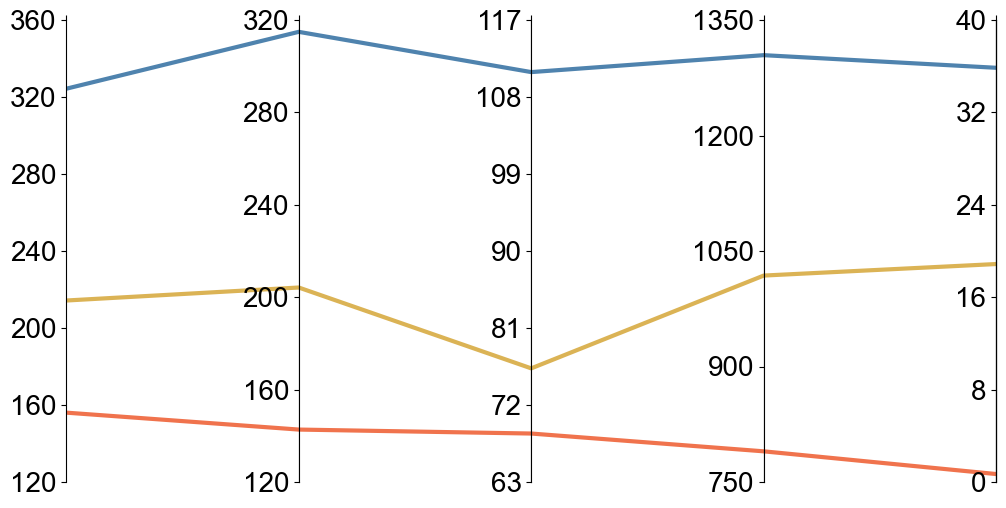

-58.24713006658973 168.2647438759663
-100 200 50
-48.8514465 148.25287999999998
-80 160 40
45.57072547196426 93.7770616067178
40 100 10
250.77734999999998 1166.29215
200 1200 200
-517.6136100000001 3.6480200000000025
-600 150 150


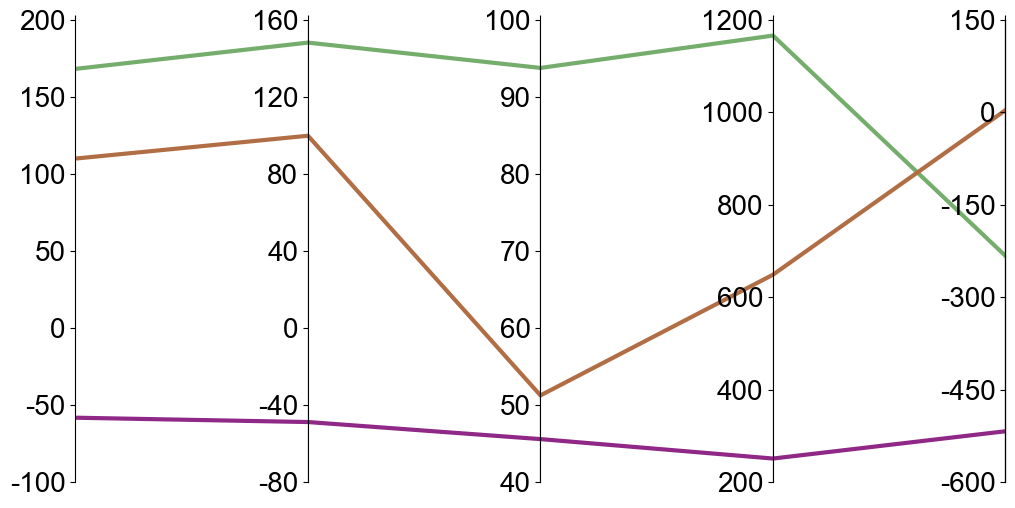

,mean,median,std,max,min
Exp1,324.294379,314.873660,110.911228,1304.32930,35.862780
Exp2,156.029635,142.698230,68.664542,789.82890,0.687605
Exp3,214.276765,204.193920,76.282574,1018.09960,18.871641
Exp1-Exp2,168.264744,148.252880,93.777062,1166.29215,-232.964730
Exp1-Exp3,110.017614,99.878140,51.246408,648.67854,3.648020
Exp2-Exp3,-58.247130,-48.851447,45.570725,250.77735,-517.613610


In [175]:
df = pd.read_csv(f'{data_path}csv/Global_cases_sr.csv')
df1 = df.copy()
stats_df = read_data(df1,'Sr_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

In [176]:
df = pd.read_csv(f'{data_path}csv/Global_cases_sb.csv')
df1 = df.copy()
stats_df = read_data(df1,'Sbedrock_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

27.280510483910806 129.20025171484406
25 150 25
21.998485000000002 119.44167
20 120 20
17.844782941046358 64.64273162003175
10 70 10
621.2877 1097.2631
600 1100 100
0.010076668 0.03777461


ZeroDivisionError: float floor division by zero

In [ ]:
df = pd.read_csv(f'{data_path}csv/Global_cases_ss.csv')
df1 = df.copy()
stats_df = read_data(df1,'Ssoil_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

In [ ]:
df = pd.read_csv(f'{data_path}csv/Global_cases_runoff_et.csv')
df1 = df.copy()
stats_df = read_data(df1,'rnof_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

In [ ]:
stats_df = read_data(df1,'fevpa_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df